In [1]:
import librosa
import matplotlib.pyplot as plt
from scipy.signal import fftconvolve
import numpy as np
import soundfile as sf

Dry Signal Length: 138033
Wet Signal Length: 138033


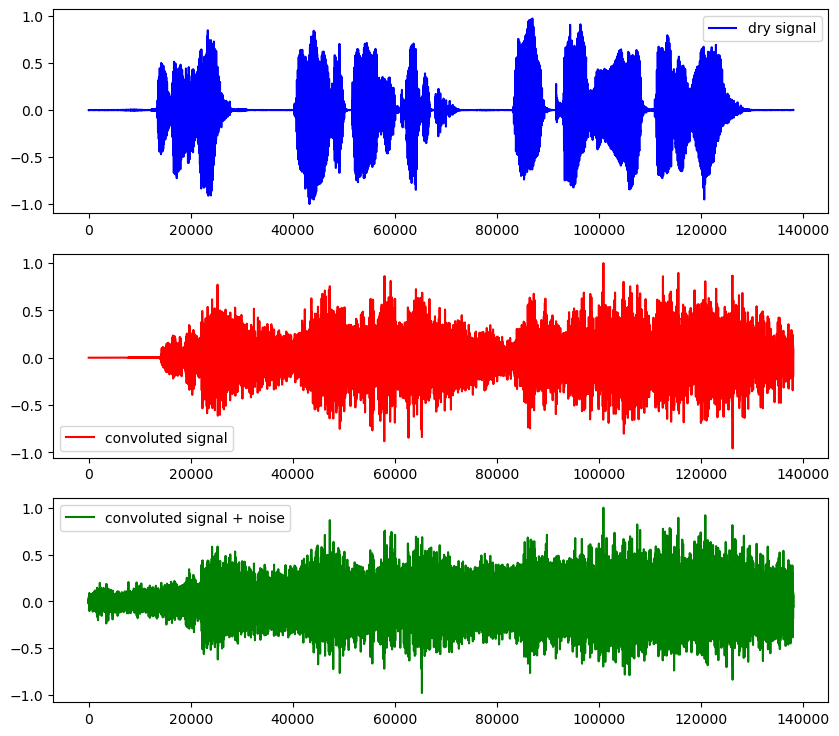

In [2]:
dry_signal_path = "/workspace/unicamp/IA009/Projeto Final/LibriSpeech/dev-clean/251/118436/251-118436-0000.flac"
ir_path = "/workspace/unicamp/IA009/Projeto Final/sports-centre-university-york/sports-centre-university-york/mono/sportscentre_cardioid.wav"
noise_path = "/workspace/unicamp/IA009/Projeto Final/noise.wav"
dry_signal, dry_signal_sr = librosa.load(dry_signal_path)
dry_signal_normalized = dry_signal/np.max(np.abs(dry_signal))
ir, ir_sr = librosa.load(ir_path)
noise, noise_sr = librosa.load(noise_path)
wet_signal = fftconvolve(dry_signal, ir, mode="full")
wet_signal = wet_signal[:len(dry_signal)]
wet_signal_normalized_ = wet_signal/np.max(np.abs(wet_signal))
wet_signal = wet_signal + noise[:len(wet_signal)]
wet_signal_normalized = wet_signal/np.max(np.abs(wet_signal))
print(f"Dry Signal Length: {len(dry_signal)}\nWet Signal Length: {len(wet_signal)}")

fig, ax = plt.subplots(3, 1, figsize=(10, 9))
ax[0].plot(dry_signal_normalized, color='blue', label='dry signal')
ax[0].legend()
ax[1].plot(wet_signal_normalized_, color='red', label='convoluted signal')
ax[1].legend()
ax[2].plot(wet_signal_normalized, color='green', label='convoluted signal + noise')
ax[2].legend()

In [5]:
import numpy as np

def rls(desired_signal, input_signal, forgetting_factor, filtering_order):
    """
    Recursive Least Squares (RLS) algorithm implementation.

    Parameters:
    - desired_signal (numpy array): The desired signal (d[n]).
    - input_signal (numpy array): The input signal (x[n]).
    - forgetting_factor (float): Forgetting factor (lambda), typically in the range (0, 1].
    - filtering_order (int): Number of coefficients in the adaptive filter.

    Returns:
    - output_signal (numpy array): The output signal (y[n]) of the filter.
    - weights (numpy array): Final weights of the filter.
    - weights_evolution (list of numpy arrays): Evolution of weights over time.
    - error_signal (numpy array): Error signal (e[n] = d[n] - y[n]).
    """
    if filtering_order >= len(desired_signal):
        raise ValueError("Filtering order must be smaller than the length of the signals.")
    
    # Initialize variables
    signal_length = len(desired_signal)
    weights = np.zeros(filtering_order)  # Filter weights
    error_signal = np.zeros(signal_length)  # Error signal
    output_signal = np.zeros(signal_length)  # Output signal
    weights_evolution = []  # Track weight evolution
    delta = 1e-6  # Small value to initialize P (avoid singularity)

    # Initialize inverse autocorrelation matrix P (identity matrix scaled by delta)
    P = np.eye(filtering_order) / delta

    for n in range(filtering_order, signal_length):
        # Select the input vector x[n] (length = filtering_order)
        input_vector = input_signal[n-filtering_order:n]

        # Compute gain vector
        Pi_x = np.dot(P, input_vector)
        gain_vector = Pi_x / (forgetting_factor + np.dot(input_vector, Pi_x))

        # Compute output signal y[n]
        output_ = np.dot(weights, input_vector)
        output_signal[n] = output_

        # Compute error signal e[n]
        error_ = desired_signal[n] - output_
        error_signal[n] = error_

        # Update filter weights
        weights += gain_vector * error_

        # Update inverse autocorrelation matrix P
        P = (P - np.outer(gain_vector, np.dot(input_vector, P))) / forgetting_factor

        # Track weights evolution
        weights_evolution.append(weights.copy())

    return output_signal, weights, weights_evolution, error_signal


# forgetting_factor = 0.99
# filtering_order = 2
# output_signal, weights, weights_evolution, error_signal = rls(
#     desired_signal=dry_signal_normalized,
#     input_signal=wet_signal_normalized,
#     forgetting_factor=forgetting_factor,
#     filtering_order=filtering_order
# )



for filtering_order in (10, 50, 100, 500, 1000, 5000, 10000):
    for forgetting_factor in (0.3, 0.5, 0.7, 0.9, 1):
        output_signal, weights, _, error_signal = rls(dry_signal_normalized, wet_signal_normalized, forgetting_factor=forgetting_factor, filtering_order=filtering_order)
        fig, ax = plt.subplots(4, 1, figsize=(10, 12))
        ax[0].plot(dry_signal_normalized, color='blue', label='dry signal')
        ax[0].legend()
        ax[1].plot(wet_signal_normalized, color='red', label='wet signal')
        ax[1].legend()
        ax[2].plot(output_signal, color="green", label="rls output signal")
        ax[2].legend()
        ax[3].plot(error_signal, color="black", label="rls error signal")
        ax[3].legend()
        # Save the plot as an image file
        image_filename = f"/workspace/unicamp/IA009/Projeto Final/rls_output/rls_output_forgetting_factor_{forgetting_factor}_filtering_order_{filtering_order}.png"
        plt.savefig(image_filename)

        # Close the plot to avoid memory issues in a loop
        plt.close(fig)
        
        # Save the output signal as a .wav file
        audio_filename = f"/workspace/unicamp/IA009/Projeto Final/rls_output/rls_output_forgetting_factor_{forgetting_factor}_filtering_order_{filtering_order}.wav"
        sf.write(audio_filename, output_signal, samplerate=22050)

/tmp/ipykernel_262715/2436688694.py:53: RuntimeWarning: overflow encountered in divide
  P = (P - np.outer(gain_vector, np.dot(input_vector, P))) / forgetting_factor
/root/anaconda3/envs/learn/lib/python3.10/site-packages/numpy/core/numeric.py:925: RuntimeWarning: overflow encountered in multiply
  return multiply(a.ravel()[:, newaxis], b.ravel()[newaxis, :], out)
/tmp/ipykernel_262715/2436688694.py:53: RuntimeWarning: overflow encountered in subtract
  P = (P - np.outer(gain_vector, np.dot(input_vector, P))) / forgetting_factor
